In [1]:
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=10 --xla_cpu_enable_fast_math=true'

import jax
print(jax.devices())

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy as np
import jax.numpy as jnp
import jax 
from jax import grad, vmap
jax.config.update("jax_enable_x64", True)




import scipy.interpolate as interp
import scipy.integrate as integ
import scipy.linalg as sla

import fisher_jim_tgr_v3 as lib
import pycbc.conversions

import astropy.units as u
from astropy import constants as const

Ms = (u.Msun * const.G / const.c**3 ).si.value
from datetime import datetime
datestr = datetime.now().strftime('%m-%d-%y')

import sys
import matplotlib as mpl

# Clear matplotlib from sys.modules
for module in list(sys.modules.keys()):
    if module.startswith("matplotlib"):
        del sys.modules[module]

import matplotlib.pyplot as plt
plt.style.use("paper.mplstyle")
%config InlineBackend.figure_format = 'retina'
pt = 1./72.27 
jour_sizes = {"PRD": {"onecol": 246.*pt, "twocol": 510.*pt},
              "CQG": {"onecol": 374.*pt}, # CQG is only one column
              # Add more journals below. Can add more properties to each journal
             }

my_width = jour_sizes["PRD"]["onecol"]
# Our figure's aspect ratio
golden = (1 + 5 ** 0.5) / 2
%config InlineBackend.figure_format = 'retina'
obj = lib.Fisher(fmin = 20, fmax = 2000, n_freq = 4000.)

[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7), CpuDevice(id=8), CpuDevice(id=9)]


In [2]:
full_str = ["M_c", "eta", "d_L", "ra", "dec", "iota", "psi", "t_c", "phase_c", "zco", "rng", "Mc_source", "snr_H1", "snr_L1", "snr_V1", "snr_t"]
names = full_str[0:9]
# data = np.loadtxt("data/events.txt")
data = jnp.array(np.loadtxt("data/5-year-data-O3/5-year-data-O3-events.txt"))
# data = jnp.array(nnp.loadtxt("data/5-year-data-CE/5-year-data-CE-events.txt"))



data_150914 = np.array(data[1])
data_150914[0] = 3
q  = 0.79
data_150914[1] = q/(1+q)**2
data_150914[2] = 390/10

idx = '150914'
# idx = '170817'
if idx=='150914':
    data_150914 = np.array(data[1])
    data_150914[0] = 30
    q  = 0.79
    data_150914[1] = q/(1+q)**2
    data_150914[2] = 390
    dat = jnp.array(data_150914)
elif idx=='170817':
    data_150914 = np.array(data[1])
    data_150914[0] = 1.2
    q  = 0.73
    data_150914[1] = q/(1+q)**2
    data_150914[2] = 390/10
    dat = jnp.array(data_150914)

red_param = dict(zip(names, jnp.array(dat).T))


epsilon = jnp.array(1e-6)
for key in ['s1_x', 's1_y', 's1_z', 's2_x', 's2_y', 's2_z']:
    red_param[key] = epsilon
zero_vector = jnp.array(0.)
for key in ['gmst', 'epoch']:
    red_param[key] = zero_vector

x = red_param.copy()
x['s1_z'] = 0.
x['s1_x'] = 0.

prec_pe = True
# prec_pe = False
if prec_pe:
    i = None
else:
    i = -2
hgr = obj.get_h_gr(x)
dhgr = obj.get_dh_gr(x)
paramgr = obj.paramdiffgr.copy()[:i]
paramgr_latex = obj.paramdiffgr_latex.copy()[:i]
freqs = obj.freqs.copy()
dets = ["H1", "L1", "V1"]

In [11]:
from scipy.sparse.linalg import eigsh
r = np.loadtxt("data/cache_delta_psi_22_v2.txt")
f_n_orig = np.loadtxt("data/cache_freq_22_v2.txt")
fend = f_n_orig[-1]


μ = np.mean(r, axis=0)
σ = np.var(r, axis=0)**(1/2)
R = r - μ
temp = np.einsum('ij,ik->jk', R, R)  # this computes the outer product of ΔΨ(f)*ΔΨ(f') as 2d array and sums it.
cov = temp/len(r[:,0]) # the two point function is the divided by the number of averages.

nλ = 1
λ, v  = eigsh(cov, nλ)
v = np.sign(v[-1,:])* v

v = 1/1e-3 / 56.41895835477563 *  np.sqrt(λ) * v

# plt.plot(f_n_orig, v)

def get_dpsi_nvnl(freqs, p):
    Mc = p["M_c"]
    eta = p["eta"]
    dPsi = np.sqrt(λ) * v[:,0]
    dPsi = dPsi- dPsi[-1]

    M = pycbc.conversions.mtotal_from_mchirp_eta(Mc,eta)*Ms
    
    # intp = interp.interp1d(f_n_orig, dPsi, kind='linear', fill_value = (0, dPsi[-1]), bounds_error=False)
    # dPsi = intp(freqs*M)
    dPsi = np.interp(freqs*M, f_n_orig, dPsi, left = 0, right = dPsi[-1])
    return dPsi


def make_Dh_nvnl_norm(x, snr=1):
    norm = get_dpsi_nvnl(np.array([20]), x) - get_dpsi_nvnl(np.array([6000]), x)
    dphik_guess = 1/norm
    dpsi = dphik_guess* get_dpsi_nvnl(freqs, x)
    h = obj.get_h_gr(x)
    Dh={}
    for d in dets:
        Dh[d] = 1j*dpsi*h[d]
    norm = np.sum([lib.innprod(Dh[d], Dh[d], obj.psdO3, obj.freqs) for d in dets])**(1/2)
    for d in dets:
        Dh[d] = Dh[d]/norm
    return Dh

def compute_Dh_nvnl_perp(dh, x, param, cov):
    Dh = make_Dh_nvnl_norm(x)
    bias_ip = obj.compute_biasip_raw(dh, Dh, x, param)
    dx_bias = np.array(cov @ bias_ip)
    dx_stat = np.diagonal(np.array(cov ))**(1/2)

    idx_par = obj.idx_par.copy()
    log_flag = obj.log_flag.copy()

    for p in filter(log_flag.__getitem__, param):
        i = idx_par[p]
        dx_bias[i] *= x[p]
        dx_stat[i] *= x[p]

    dhpara, dhperp = {}, {}
    for d in dets:
        dhpara[d] = sum((dx_bias[idx_par[p]] * dh[d][p] for p in param), jnp.zeros_like(freqs))
        dhperp[d] = Dh[d] - dhpara[d]
    
    if True:
        dperpnorm = [lib.innprod(dhperp[d], dhperp[d], obj.psdO3, obj.freqs) for d in dets]
        dperpnorm = np.sum(dperpnorm)**(1/2)

        for d in dets:
            dhperp[d] = dhperp[d] / dperpnorm
            Dh[d] = Dh[d] / dperpnorm
    return dhperp, Dh

In [12]:
def make_Dh_ppe(kinj, dphik, x, norm_dh = False):
    Dh = {}
    dpsi_inj = dphik*lib.get_dpsi_ppe(obj.freqs, x, kinj)
    for d in dets:
        Dh[d] = 1j * dpsi_inj * hgr[d] 
    if norm_dh:
        normarr = [lib.innprod(Dh[d], Dh[d], obj.psdO3, obj.freqs) for d in dets]
        norm = np.sum(normarr)**(1/2)
        dpsi_inj = dpsi_inj/norm
        for d in dets:
            Dh[d] = Dh[d]/norm
    return Dh

def make_Dh_ppe_norm(kinj, x, snr=1):
    norm = lib.get_dpsi_ppe(20, x, kinj)- lib.get_dpsi_ppe(6000, x, kinj)
    dphik_guess = 1/norm
    Dh = make_Dh_ppe(kinj, dphik_guess, x, norm_dh = True)
    for d in dets:
        Dh[d] = Dh[d]/snr
    return Dh

def compute_Dh_ppek_perp(k, dh, x, param, cov):
    Dh = make_Dh_ppe_norm(k, x)
    if k==5:
        for d in dets:
            Dh[d] = Dh[d]*0
    bias_ip = obj.compute_biasip_raw(dh, Dh, x, param)
    dx_bias = np.array(cov @ bias_ip)
    dx_stat = np.diagonal(np.array(cov ))**(1/2)

    idx_par = obj.idx_par.copy()
    log_flag = obj.log_flag.copy()

    for p in filter(log_flag.__getitem__, param):
        i = idx_par[p]
        dx_bias[i] *= x[p]
        dx_stat[i] *= x[p]

    dhpara, dhperp = {}, {}
    for d in dets:
        dhpara[d] = sum((dx_bias[idx_par[p]] * dh[d][p] for p in param), jnp.zeros_like(freqs))
        dhperp[d] = Dh[d] - dhpara[d]
    
    if k!=5:
        dperpnorm = [lib.innprod(dhperp[d], dhperp[d], obj.psdO3, obj.freqs) for d in dets]
        dperpnorm = np.sum(dperpnorm)**(1/2)

        for d in dets:
            dhperp[d] = dhperp[d] / dperpnorm
            Dh[d] = Dh[d] / dperpnorm
    return dhperp, Dh



dh = obj.get_dh_gr(x)
fi = obj.compute_fisher_raw(dhgr, x, paramgr)
# kk = np.array(list(obj.k2str.keys()))
cov = jnp.linalg.inv(fi)
res = {}
resDh = {}
kk = np.array(list(obj.k2str.keys()))
for k in kk:
    dhperp, Dh = compute_Dh_ppek_perp(k, dhgr, x, paramgr, cov)
    res[obj.k2str[k]] = dhperp
    resDh[obj.k2str[k]] = Dh
# res = compute_Dh_ppek_perp(kk[0], dhgr, x, paramgr, cov)
dhperp_nvnl, Dh_nvnl = compute_Dh_nvnl_perp(dhgr, x, paramgr, cov)

In [19]:
len(kkvals)

9

In [23]:
kkvals = kk[kk != 5]  # This removes 5 from the array

ff = np.zeros((len(kkvals)+1,len(kkvals)+1),dtype=np.complex128)
for i in range(len(kkvals)):
    for j in range(len(kkvals)):
        dh_1 = res[obj.k2str[kkvals[i]]]
        dh_2 = res[obj.k2str[kkvals[j]]]

        ff[i,j] = np.sum([lib.innprod(dh_1[d], dh_2[d], obj.psdO3, obj.freqs) for d in dets])



for i in range(len(kkvals)):
    dh_1 = res[obj.k2str[kkvals[i]]]
    dh_2 = dhperp_nvnl

    ff[i,len(kkvals)] = np.sum([lib.innprod(dh_1[d], dh_2[d], obj.psdO3, obj.freqs) for d in dets])
    ff[len(kkvals), i] = ff[i,len(kkvals)]

ff[len(kkvals),len(kkvals)] = np.sum([lib.innprod(dhperp_nvnl[d], dhperp_nvnl[d], obj.psdO3, obj.freqs) for d in dets])

ff = np.real(ff)

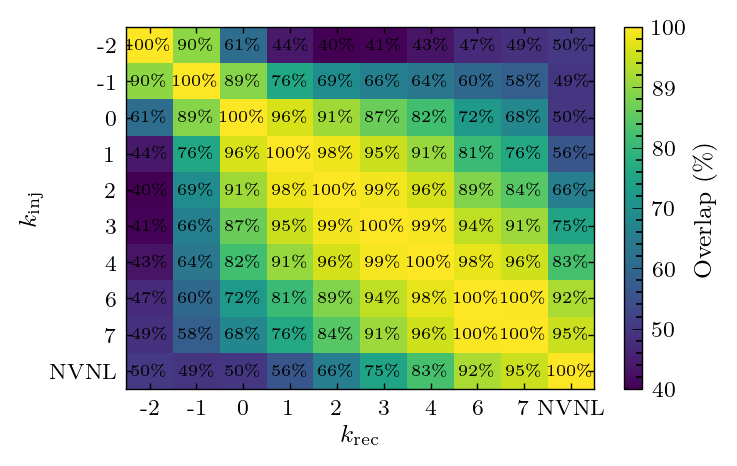

In [34]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter



fig = plt.figure(figsize = (my_width, my_width/golden),dpi=100)
ax = fig.gca()

mmarr = np.abs(ff)

# Ensure values are between 0 and 1 for percentage representation
mmarr_safe = np.clip(mmarr, 0, 1)

# Define levels for percentage scale (0% to 100%)
levels = np.linspace(0.4, 1, 7)
normbar = mcolors.Normalize(vmin=0.4, vmax=1)

# Plot using percentage scale
plt.imshow(mmarr_safe, cmap='viridis', interpolation='nearest', aspect='auto', norm=normbar)

# Add discrete color bar
cbar = plt.colorbar(ticks=levels)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x * 100)}"))
cbar.set_label(r'Overlap (\%)')

# Label axes
plt.xlabel(r"$k_{\mathrm{rec}}$")
plt.ylabel(r"$k_{\mathrm{inj}}$")

# Annotate each cell with percentage values
for i in range(len(kkvals)+1):
    for j in range(len(kkvals)+1):
        text = fr"{mmarr_safe[i, j] * 100:.0f}\%"  # Convert to percentage
        ax.text(j, i, text, ha="center", va="center", color="k", fontsize=6, weight="bold")

# Set tick labels
labels = np.append(kkvals, "NVNL")
plt.xticks(ticks=np.arange(len(labels)), labels=labels)
plt.yticks(ticks=np.arange(len(labels)), labels=labels)

# Adjust tick parameters
ax.tick_params(which='minor', bottom=False, left=False, top=False, right=False)
ax.tick_params(axis='x', length=2, width=0.5)  # Make x-tick marks smaller
ax.tick_params(axis='y', length=2, width=0.5)  # Make y-tick marks smaller

# plt.savefig("ff-pn-tests-spin.pdf", bbox_inches='tight', pad_inches=0)
# plt.savefig("ff-pn-tests-nospin.pdf", bbox_inches='tight', pad_inches=0)
# plt.savefig("ff-pn-tests-spin-bns.pdf", bbox_inches='tight', pad_inches=0)
# plt.savefig("ff-pn-tests-nospin-bns.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [61]:
x = red_param.copy()
mm = np.linspace(5,80,131)
kk = np.array(list(obj.k2str.keys()))

kkvals = kk[kk != 5]
ol = np.zeros((len(kkvals),len(mm)),dtype=np.complex128)
for m_idx, m in enumerate(mm):
    y = x.copy()
    y["M_c"] = jnp.array(m, dtype=jnp.float64)
    hgr = obj.get_h_gr(y)
    dhgr = obj.get_dh_gr(y)
    fi = obj.compute_fisher_raw(dhgr, y, paramgr)
    # kk = np.array(list(obj.k2str.keys()))
    cov = jnp.linalg.inv(fi)
    res = {}
    resDh = {}
    
    dhperp_nvnl, Dh_nvnl = compute_Dh_nvnl_perp(dhgr, y, paramgr, cov)

    for i in range(len(kkvals)):
        k = kkvals[i]
        dhperp, Dh = compute_Dh_ppek_perp(k, dhgr, y, paramgr, cov)
        ol[i,m_idx]= np.sum([lib.innprod(dhperp_nvnl[d], dhperp[d], obj.psdO3, obj.freqs) for d in dets])



/tmp/ipykernel_2169264/3227889205.py:37: RuntimeWarning: divide by zero encountered in divide
  dphik_guess = 1/norm
/tmp/ipykernel_2169264/3227889205.py:38: RuntimeWarning: invalid value encountered in multiply
  dpsi = dphik_guess* get_dpsi_nvnl(freqs, x)
/tmp/ipykernel_2169264/3227889205.py:42: RuntimeWarning: invalid value encountered in multiply
  Dh[d] = 1j*dpsi*h[d]


/home/darkknight/anaconda3/envs/geotgr/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/darkknight/anaconda3/envs/geotgr/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


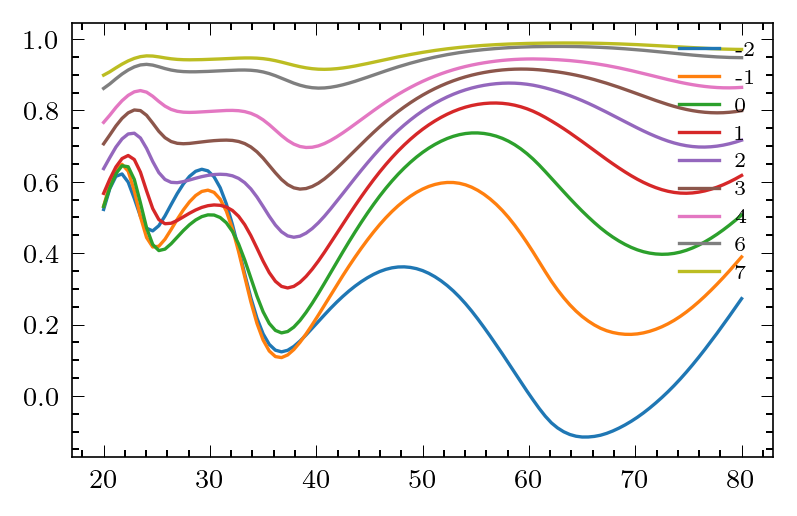

In [62]:
for i in range(len(kkvals)):
    plt.plot(mm,ol[i], label = f"{kkvals[i]}")
plt.legend(loc=1)